In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [10]:
tweets_ratio_data = '..\\sentiment\\tweets_ratios.csv'
corona_ratio_data = '..\\sentiment\\corona_lb_ratios.csv'

pd.set_option('display.max_rows', 255)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [11]:
df = pd.read_csv(tweets_ratio_data, header=0)
# df.head()

# all days groups have same ratios value so all first()/min()/max()/mean() work here

In [12]:
days = df.groupby(['month', 'day']).first()['ratio_sentiment3'].reset_index()

In [13]:
# days

In [14]:
x = days.month.map(str) + '_' + days.day.map(str)
y = days.ratio_sentiment3

zero = [0 for _ in range(len(x))]

mean_value = days.ratio_sentiment3.mean()
median = [mean_value for _ in range(len(x))]

max_value = days.ratio_sentiment3.max()
maximum = [max_value for _ in range(len(x))]

min_value = days.ratio_sentiment3.min()
minimum = [min_value for _ in range(len(x))]

std_value = days.ratio_sentiment3.std()
pos_std = [std_value for _ in range(len(x))]
neg_std = [-std_value for _ in range(len(x))]

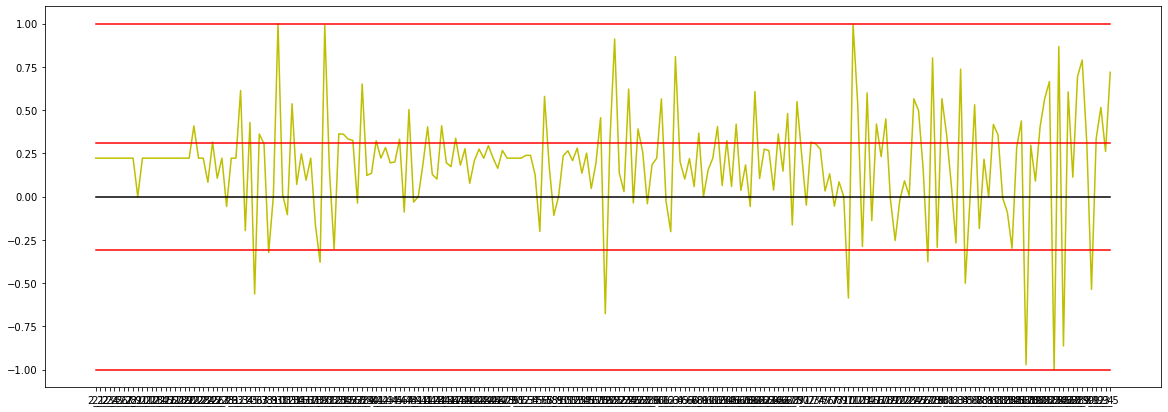

In [15]:
plt.figure(figsize=(20, 7))

plt.plot(
    x, y, 'y', 
    x, zero, 'black', 
#     x, median, 'b', 
    x, maximum, 'r', 
    x, minimum, 'r', 
    x, pos_std, 'r',
    x, neg_std, 'r'
)

In [16]:
hotspots_dict = {}
hotspots = []
for index, row in days.iterrows():
    if row.ratio_sentiment3 >= std_value or row.ratio_sentiment3 <= -std_value:
        hotspots_dict[(row.month, row.day)] = row.ratio_sentiment3
        hotspots.append(row.ratio_sentiment3)
    else:
        hotspots.append(0)
    
print(len(hotspots_dict))
print(len(hotspots))

72
218


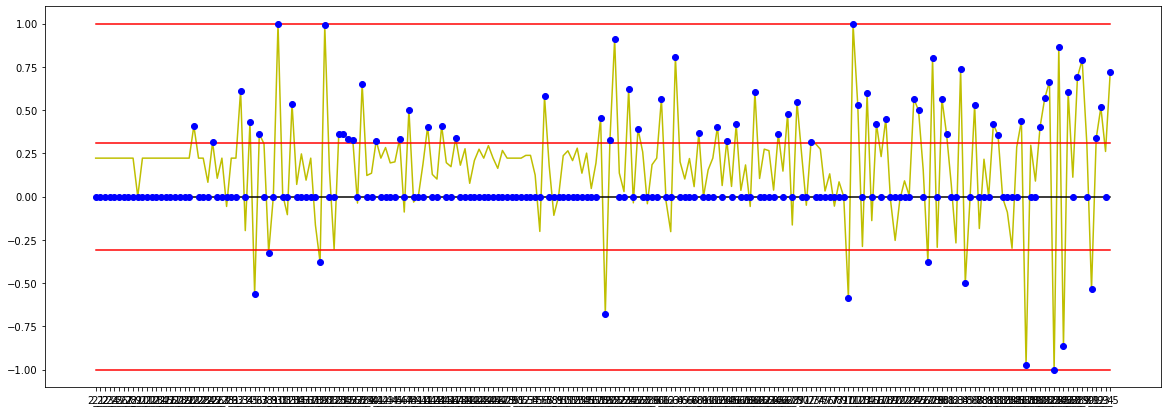

In [17]:
plt.figure(figsize=(20, 7))
plt.plot(
    x, y, 'y', 
    x, zero, 'black',
    x, maximum, 'r', 
    x, minimum, 'r', 
    x, pos_std, 'r',
    x, neg_std, 'r',
    x, hotspots, 'bo'
)

In [18]:
mask = df.apply(lambda row: True if hotspots_dict.get((row.month, row.day), None) else False, axis=1)
hotspots_data = df[mask]
len(hotspots_data)

17575

In [19]:
def tf_idf(data, stopwords=None, max_features=1000, ngram=(1, 1)):
    tf_Idf = TfidfVectorizer(stop_words=stopwords, max_features=max_features, ngram_range=ngram)
    tf_Idf_fit = tf_Idf.fit_transform(data)
    feature_names = tf_Idf.get_feature_names()
    
    dense = tf_Idf_fit.todense()
    denselist = dense.tolist()

    tf_idf_table = pd.DataFrame(denselist, columns=feature_names)

    tf_idf_result = pd.DataFrame()
    tf_idf_result[['topic', 'score']] = tf_idf_table.mean().reset_index()
    tf_idf_result = tf_idf_result.sort_values('score', ascending=False).reset_index(drop=True)
    return tf_idf_result
        
numeric = re.compile(r'\w*\d+\w*')
def accepted_word(w):
    return len(w) > 2 and re.search(numeric, w) is None

In [20]:
data_removed = hotspots_data.text.apply(lambda s: " ".join([w for w in s.split() if not accepted_word(w)]))
stopwords = " ".join(data_removed).split()

In [21]:
len(stopwords)

73012

In [23]:
corona_data = pd.read_csv(corona_ratio_data, header=0)

sentiment_ratio_dict = {}
for index, row in corona_data.iterrows():    
    key = (row.month, row.day)
    sentiment_ratio_dict[key] = {
        'prev_cases': int(row.prev_cases),
        'new_cases': int(row.new_cases),
        'total_cases': int(row.total_cases),
        'prev_deaths': int(row.prev_deaths),
        'new_deaths': int(row.new_deaths),
        'total_deaths': int(row.total_deaths),
        'sentiment_ratio1': row.sentiment_ratio1,
        'sentiment_ratio2': row.sentiment_ratio2,
        'sentiment_ratio3': row.sentiment_ratio3,
        'sentiment_ratio4': row.sentiment_ratio4,
    }

In [24]:
hotspots_groups = hotspots_data.groupby(['month', 'day'])
print(len(hotspots_groups.groups))

72


In [27]:
for g_key, g_data in hotspots_groups:
    topics = tf_idf(g_data.text, stopwords=stopwords, ngram=(2, 3))
    topics = topics.loc[:50]
    
    m, d = g_key
    details = sentiment_ratio_dict.get(g_key, None)
    
    print('[Month]:', m)
    print('[Day]:', d)
    
    if details:
        print('[Prev Cases]:', details['prev_cases'])
        print('[New Cases]:', details['new_cases'])
        print('[Prev Cases - New Cases]:', details['prev_cases'] - details['new_cases'])
        print('[Prev Deaths]:', details['prev_deaths'])
        print('[New Deaths]:', details['new_deaths'])
        print('[Prev Deaths - New Deaths]:', details['prev_deaths'] - details['new_deaths'])
        
    print('[Ratio]:', g_data.ratio_sentiment3.mean())
    print('[Topics]:', list(topics.topic))
    print('-----------------------------------------------------------')

[Month]: 2
[Day]: 22
[Prev Cases]: 1
[New Cases]: 0
[Prev Cases - New Cases]: 1
[Prev Deaths]: 1
[New Deaths]: 0
[Prev Deaths - New Deaths]: 1
[Ratio]: 0.4087380298853168
[Topics]: ['twitter com', 'pic twitter com', 'pic twitter', 'https twitter com', 'https twitter', 'كورونا_لبنان pic twitter', 'كورونا_لبنان pic', 'medical center', 'bit ly', 'http bit ly', 'http bit', 'معي كورونا', 'corona virus', 'كورونا جراد', 'كورونا_لبنان الجراد', 'كورونا كورونا_لبنان', 'على لبنان', 'lebanon http', 'syrian refugees', 'healthcare lebanon', 'وزير الصحة', 'كورونا_لبنان https', 'كورونا_لبنان https twitter', 'بفيروس كورونا', 'healthcare job', 'healthcare http', 'وقف الرحلات الجوية', 'وقف الرحلات', 'الرحلات الجوية', 'kindred healthcare', 'مين قال', 'أول حالة', 'حتى الآن', 'the syrian', 'داعي للهلع', 'كورونا mtvirus', 'ولكن هذه', 'com saudi24_tv', 'com saudi24_tv status', 'twitter com saudi24_tv', 'saudi24_tv status', 'ليش حاسس', 'كورونا pic', 'كورونا pic twitter', 'أول حالة كورونا', 'حالة كورونا', 'بإفر

[Month]: 3
[Day]: 20
[Prev Cases]: 22
[New Cases]: 48
[Prev Cases - New Cases]: -26
[Prev Deaths]: 3
[New Deaths]: 2
[Prev Deaths - New Deaths]: 1
[Ratio]: -0.37932058430389465
[Topics]: ['twitter com', 'pic twitter com', 'pic twitter', 'https twitter com', 'https twitter', 'فيروس كورونا', 'كورونا لبنان', 'لبنان كورونا', 'كورونا pic twitter', 'كورونا pic', 'medical center', 'covid_19 https twitter', 'covid_19 https', 'بفيروس كورونا', 'كورونا_لبنان https', 'كورونا_لبنان https twitter', 'covid_19 coronavirusupdate', 'كورونا https', 'خليك_بالبيت كورونا', 'https www', 'coronavirusupdate covid_19', 'كورونا covid_19', 'the world', 'كورونا_لبنان pic', 'كورونا_لبنان pic twitter', 'the medical', 'حسن كورونا', 'كورونا خليك_بالبيت', 'بسبب انتشار', 'لبنان pic', 'لبنان pic twitter', 'قبل كورونا', 'كورونا ولا', 'كورونا https twitter', 'and the', 'medical and', 'time crisis', 'خليك_بالبيت لبنان', 'وباء كورونا', 'زمن كورونا', 'فايروس كورونا', 'the healthcare', 'أزمة كورونا', 'com saudi24_tv', 'saudi24

[Month]: 4
[Day]: 1
[Prev Cases]: 17
[New Cases]: 15
[Prev Cases - New Cases]: 2
[Prev Deaths]: 1
[New Deaths]: 0
[Prev Deaths - New Deaths]: 1
[Ratio]: 0.3229942177758435
[Topics]: ['كورونا لبنان', 'twitter com', 'pic twitter com', 'pic twitter', 'كورونا_لبنان كورونا', 'كورونا_لبنان خليك_بالبيت', 'كورونا كورونا_لبنان', 'خليك_بالبيت كورونا_لبنان', 'لبنان كورونا_لبنان', 'https twitter', 'https twitter com', 'بفيروس كورونا', 'covidー19 كورونا_لبنان', 'كورونا_الجديد كورونا_لبنان', 'فيروس_كورونا لبنان', 'فيروس كورونا', 'الحجر الصحي', 'bit ly', 'medical center', 'كورونا_لبنان covidー19', 'كورونا_لبنان لبنان', 'https www', 'التعبئة العامة', 'خليك_بالبيت خليك_في_البيت', 'فايروس كورونا', 'لبنان_ينتفض كورونا_لبنان', 'the world', 'كورونا_الجديد كورونا', 'healthcare lebanon', 'رتيب سرية', 'http bit', 'http bit ly', 'كورونا على', 'covidー19 coronavirus', 'كورونا_لبنان لبنان_ينتفض', 'كورونا فيروس_كورونا', 'كورونا_لبنان خليك_في_البيت', 'كورونا_لبنان كورونا_فيروس', 'covidー19 كورونا', 'الشعب اللبناني', '

[Month]: 5
[Day]: 21
[Prev Cases]: 64
[New Cases]: 62
[Prev Cases - New Cases]: 2
[Prev Deaths]: 1
[New Deaths]: 0
[Prev Deaths - New Deaths]: 1
[Ratio]: 0.3292223551014817
[Topics]: ['كورونا_لبنان خليك_بالبيت', 'كورونا لبنان', 'كورونا_لبنان لبنان', 'كورونا_لبنان لبنان_ينتفض', 'وزارة الصحة', 'كورونا_لبنان كورونا', 'خليك_بالبيت كورونا_لبنان', 'كورونا كورونا_لبنان', 'covid_19 كورونا_لبنان', 'twitter com', 'إصابة جديدة', 'حالة كورونا', 'لبنان_ينتفض كورونا_لبنان', 'كورونا_لبنان covid_19', 'medical marijuana', 'وعي الشعب', 'اصابة جديدة', 'بلا_مخ كورونا_لبنان', 'bit ly', 'حسان دياب', 'لبنان كورونا_لبنان', 'pic twitter com', 'pic twitter', 'اليوم كورونا_لبنان', 'بفيروس كورونا', 'فيروس كورونا', 'مجدل عنجر', 'for the', 'لبنان_ينتفض لبنان', 'syrian refugees', 'جديدة اليوم', 'عدد الاصابات', 'جديدة بفيروس', 'عدد الإصابات', 'عيد_الفطر كورونا_لبنان', 'فايروس كورونا', 'lebanon http', 'تسجيل إصابة', 'على وعي', 'شعب لبنان', 'الدولار كورونا_لبنان', 'بالبيت كورونا_لبنان', 'marijuana dispensary', 'medical

[Month]: 6
[Day]: 15
[Prev Cases]: 18
[New Cases]: 9
[Prev Cases - New Cases]: 9
[Prev Deaths]: 0
[New Deaths]: 0
[Prev Deaths - New Deaths]: 0
[Ratio]: 0.32364519930692487
[Topics]: ['medical center', 'كورونا لبنان', 'bit ly', 'تسجيل إصابة جديدة', 'تسجيل إصابة', 'إصابة جديدة', 'dartmouth hitchcock', 'syrians lebanon', 'lebanon medical', 'twitter com', 'http fb', 'lebanon http', 'the total', 'treatment refugeelives', 'hitchcock medical', 'dartmouth hitchcock medical', 'ult4uo lebanon cmo', 'المفرد والمجوز كتير', 'المفرد والمجوز', 'ult4uo lebanon', 'الصين حتقدر تغمض', 'تغمض عنيك كورونا', 'عنيك كورونا', 'تغمض عنيك', 'الصين حتقدر', 'حتقدر تغمض', 'حتقدر تغمض عنيك', 'they are', 'ارتفاع إصابات كورونا', 'ارتفاع إصابات', 'مخاوف ارتفاع', 'مخاوف ارتفاع إصابات', 'إصابات كورونا', 'كورونا لبنان_ينتفض', 'bit ly 1bcwey2', 'pic twitter', 'pic twitter com', 'lebanon medical center', 'medical care', 'بفيروس كورونا', 'instagram com', 'https instagram', 'https instagram com', 'الكورونا 06 كورونا', 'آخر مس

[Month]: 7
[Day]: 13
[Prev Cases]: 85
[New Cases]: 32
[Prev Cases - New Cases]: 53
[Prev Deaths]: 0
[New Deaths]: 2
[Prev Deaths - New Deaths]: -2
[Ratio]: 0.5302544747196337
[Topics]: ['twitter com', 'http fb', 'pic twitter', 'pic twitter com', 'cheap medical', 'awesome and', 'awesome and cheap', 'and cheap medical', 'and cheap', 'corona cases', 'cases today', 'corona cases today', 'http tinyurl com', 'tinyurl com', 'http tinyurl', 'lebanon healthcare', 'beirut lebanon', 'تسك البلد', 'for cardiac anesthesiologist', 'anesthesiologist lebanon', 'for cardiac', 'cardiac anesthesiologist', 'cardiac anesthesiologist lebanon', 'http ow', 'http ow ly', 'ow ly', 'https twitter com', 'https twitter', 'medical experience', 'cheap medical experience', 'medical experience lebanon', 'experience lebanon', 'healthcare jobs', 'medical assistant', 'ws nd7em6', 'ws nd7em6 healthcare', 'health care', 'lebanon assumes responsibilities', 'good samaritan', 'medical secretary good', 'medical secretary', 'hea

[Month]: 8
[Day]: 1
[Prev Cases]: 175
[New Cases]: 155
[Prev Cases - New Cases]: 20
[Prev Deaths]: 0
[New Deaths]: 0
[Prev Deaths - New Deaths]: 0
[Ratio]: 0.360455219325594
[Topics]: ['كورونا لبنان', 'twitter com', 'covid_19 كورونا', 'the total', 'كورونا كورونا_لبنان', 'pic twitter com', 'pic twitter', 'https www', 'بفيروس كورونا', 'https www zahle24', 'zahle24 com', 'www zahle24 com', 'www zahle24', 'رفعت العدد', 'جديدة بفيروس', 'جديدة بفيروس كورونا', 'إصابة جديدة', 'instagram com', 'https instagram com', 'https instagram', 'حالتي وفاة', 'اصابة جديدة بفيروس', 'اصابة جديدة', 'حالة كورونا', 'كورونا_لبنان covid_19', 'فيروس كورونا', 'حالتا وفاة', 'بفيروس كورونا لبنان', 'd8 d8', 'ماشيين تبزقوا بعض', 'ماشيين تبزقوا', 'تبزقوا بعض', 'وزير الصحة', 'الاصابات كورونا_لبنان', 'd9 d8', 'كورونا اليوم', 'lebanon https', 'كمان لان كورونا', 'كمان لان', 'كورونا_لبنان لبنان', 'لبنان_ينهار كورونا', 'حاجياته كورونا لبنان', 'حاجياته كورونا', 'بين يلي', 'https twitter com', 'https twitter', 'حالتا وفاة رفعت

[Month]: 8
[Day]: 22
[Prev Cases]: 611
[New Cases]: 507
[Prev Cases - New Cases]: 104
[Prev Deaths]: 1
[New Deaths]: 4
[Prev Deaths - New Deaths]: -3
[Ratio]: 0.5694734935631898
[Topics]: ['كورونا لبنان', 'كورونا كورونا_لبنان', 'لبنان كورونا_لبنان', 'lebanon beirut', 'and medical', 'لبنان بيروت', 'medical supplies', 'lebanon the', 'after the', 'active cases', 'the total', 'new cases', 'explosion beirut', 'medical aid', 'كورونا_لبنان كورونا', 'the world', 'room for', 'العصر كورونا_لبنان', 'كورونا لبنان بيروت', 'bit ly', 'اصابة جديدة', 'less than', 'our planet', 'كورونا_لبنان خليك_بالبيت', 'بفيروس كورونا', 'food and medical', 'food and', 'has been', 'and medical supplies', 'affected the', 'are the', 'جديدة بفيروس', 'جديدة بفيروس كورونا', 'جديدة كورونا', 'بيروت كورونا_لبنان', 'كورونا_لبنان لبنان', 'بيروت لبنان', 'بيروت لبنان كورونا_لبنان', 'تسجيل إصابات', 'تسجيل إصابات جديدة', 'إصابات جديدة', 'موقع_بالمختصر كورونا_لبنان لبنان', 'موقع_بالمختصر كورونا_لبنان', 'القطاع الصحي', 'وزارة الصحه', 

[Month]: 9
[Day]: 2
[Prev Cases]: 588
[New Cases]: 588
[Prev Cases - New Cases]: 0
[Prev Deaths]: 6
[New Deaths]: 4
[Prev Deaths - New Deaths]: 2
[Ratio]: 0.3367426196212613
[Topics]: ['كورونا لبنان', 'إصابة جديدة', 'كورونا كورونا_لبنان', 'بفيروس كورونا', 'the hospital', 'وفيات إصابة', 'وفيات إصابة جديدة', 'active cases', 'covid and', 'bit ly', 'corona virus', 'جديدة بفيروس', 'جديدة بفيروس كورونا', 'the hospital exceptional', 'and medical', 'work permit', 'work permit eligibility', 'the elderly', 'the elderly warlords', 'واخيرا خبر حلو', 'واخيرا خبر', 'tourisme covid les', 'tourisme covid', 'the spread', 'the spread covid', 'the total', 'كورونا لبنان وعيك_امانه', 'لبنان وعيك_امانه', 'wheat lebanon', 'اللبنانية تسجيل', 'إصابة جديدة بفيروس', 'حالات وفاة', 'new cases', 'medical supplies', 'وزارة الصحة', 'الصحة اللبنانية', 'وزارة الصحة اللبنانية', 'لبنان كورونا_لبنان', 'due the', 'لبنان كورونا', 'will live', 'the will', 'the will live', 'https instagram com', 'instagram com', 'https instag

# Conclusion - No use, better get hotspots days and get all tweets/#hashtags on that day (not the corona tweets i have)